In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
import pingouin as pg
import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [3]:
# Load file (from same directory as the notebook)/

df = pd.read_excel(os.path.expanduser("nested.xlsx"))
df.head()

,ParticipantID,PAIR,Epistemic,PARTNER Agreement:,PA_fact1,PA_fact2,PA_fact3,PA_fact4,PA_fact5,PA_fact6,...,Ide,MEDIA,SocialMEDIA,PREVENT,Unnamed: 202,FACT_AGREE,MISINFO_AGREE,CONSPIRACY_AGREE,Unnamed: 206,SocialSensitivity
0,1101,36,100,NaN,0,0,0,0,0,0,...,4,6,4,5.857143,NaN,0,-1,0,NaN,0.352664
1,1102,37,100,NaN,0,0,0,0,0,0,...,1,2,6,10.000000,NaN,0,0,-1,NaN,0.175614
2,1106,38,100,NaN,0,0,0,0,0,0,...,5,6,0,10.000000,NaN,3,0,2,NaN,0.524490
3,1108,36,100,NaN,0,0,0,0,0,0,...,9,13,14,10.000000,NaN,0,-1,0,NaN,-0.036627
4,1112,39,100,NaN,0,0,0,0,0,0,...,6,2,5,10.000000,NaN,5,1,1,NaN,-0.125586


In [4]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
participant = df.loc[:,"ParticipantID"]

# Extract data with df.loc[:,"datastart":"dataend"]
PartAgree = df.loc[:, "PA_fact1":"PA_con4"]
SelfAgree = df.loc[:, "SA_fact1":"SA_con4"]
Change = df.loc[:, "Change_fact1":"Change_con4"]
pre = df.loc[:, "pre1":"pre22"]
# Item categories (hard-code this!)
FMC = np.array(9*["Fact"] + 9*["Myth"] + 4*["Conspiracy"])[np.newaxis, :]
pair = np.array(df.loc[:, "PAIR"])[:, np.newaxis]
epistemic = np.array(df.loc[:, "Epistemic"])[:, np.newaxis]


sz = Change.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["SpeakAgree", "SelfAgree", "Change", "pre", "FMC", "pair",'epistemic', "itemnum", "partnum"]
data_packed = np.broadcast_arrays(PartAgree, SelfAgree, Change, pre, FMC, pair,epistemic, itemnum, partnum)
data_unpacked = [np.reshape(a, -1) for a in data_packed]

DATA = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, data_unpacked)})

nparticipant = int(DATA["partnum"].max())+1
lmh_all = []
lmh = [0]*7 + [1]*8 + [2]*7
for p in range(nparticipant):
    idx = np.argsort(DATA.loc[DATA["partnum"]==p, "pre"])
    lmh_sorted = [x for _, x in sorted(zip(idx, lmh))]
    lmh_all += lmh_sorted
DATA.insert(5, "LMH", lmh_all)

map_dict = {0: "Low", 1: "aMod", 2: "High"}
DATA.insert(6,"lmh",DATA["LMH"].map(map_dict))

DATA.head()

,SpeakAgree,SelfAgree,Change,pre,FMC,LMH,lmh,pair,epistemic,itemnum,partnum
0,0,0.0,1,9,Fact,2,High,36,100,0,0
1,0,0.0,0,2,Fact,1,aMod,36,100,1,0
2,0,0.0,2,5,Fact,1,aMod,36,100,2,0
3,0,0.0,0,10,Fact,2,High,36,100,3,0
4,0,0.0,0,5,Fact,1,aMod,36,100,4,0


In [5]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
# %R library(lme4)

%R library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [6]:
%Rpush DATA

In [13]:
%%R

M <- lmer(Change ~ pre + SpeakAgree + SelfAgree  + (1|itemnum) + (1|pair/partnum), data = DATA)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Change ~ pre + SpeakAgree + SelfAgree + (1 | itemnum) + (1 |  
    pair/partnum)
   Data: DATA

REML criterion at convergence: 10105.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9165 -0.3572 -0.0427  0.3845  5.5547 

Random effects:
 Groups       Name        Variance  Std.Dev. 
 partnum:pair (Intercept) 1.115e-01 0.3339757
 pair         (Intercept) 2.227e-08 0.0001492
 itemnum      (Intercept) 2.016e-01 0.4489697
 Residual                 2.726e+00 1.6511271
Number of obs: 2595, groups:  partnum:pair, 118; pair, 59; itemnum, 22

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    0.67483    0.11587   30.17919   5.824 2.23e-06 ***
pre           -0.16862    0.01115 1570.36625 -15.118  < 2e-16 ***
SpeakAgree     0.24861    0.06444 2568.54461   3.858 0.000117 ***
SelfAgree      0.27888    0.06259 2561.05679   4.456 8.71e-06 ***
---


In [14]:
%%R
M <- lmer(Change ~ pre + SpeakAgree:FMC + SelfAgree  + (1|itemnum) + (1|pair/partnum), data = DATA)

print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Change ~ pre + SpeakAgree:FMC + SelfAgree + (1 | itemnum) + (1 |  
    pair/partnum)
   Data: DATA

REML criterion at convergence: 10102.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0140 -0.3555 -0.0447  0.3844  5.5869 

Random effects:
 Groups       Name        Variance  Std.Dev. 
 partnum:pair (Intercept) 1.112e-01 0.3334477
 pair         (Intercept) 2.575e-07 0.0005075
 itemnum      (Intercept) 1.921e-01 0.4382352
 Residual                 2.722e+00 1.6499275
Number of obs: 2595, groups:  partnum:pair, 118; pair, 59; itemnum, 22

Fixed effects:
                           Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                 0.65901    0.11404   30.48284   5.779 2.45e-06 ***
pre                        -0.16799    0.01113 1513.17594 -15.096  < 2e-16 ***
SelfAgree                   0.28594    0.06341 2563.50665   4.510 6.79e-06 ***
SpeakAgree:FMC

<IPython.core.display.Javascript object>


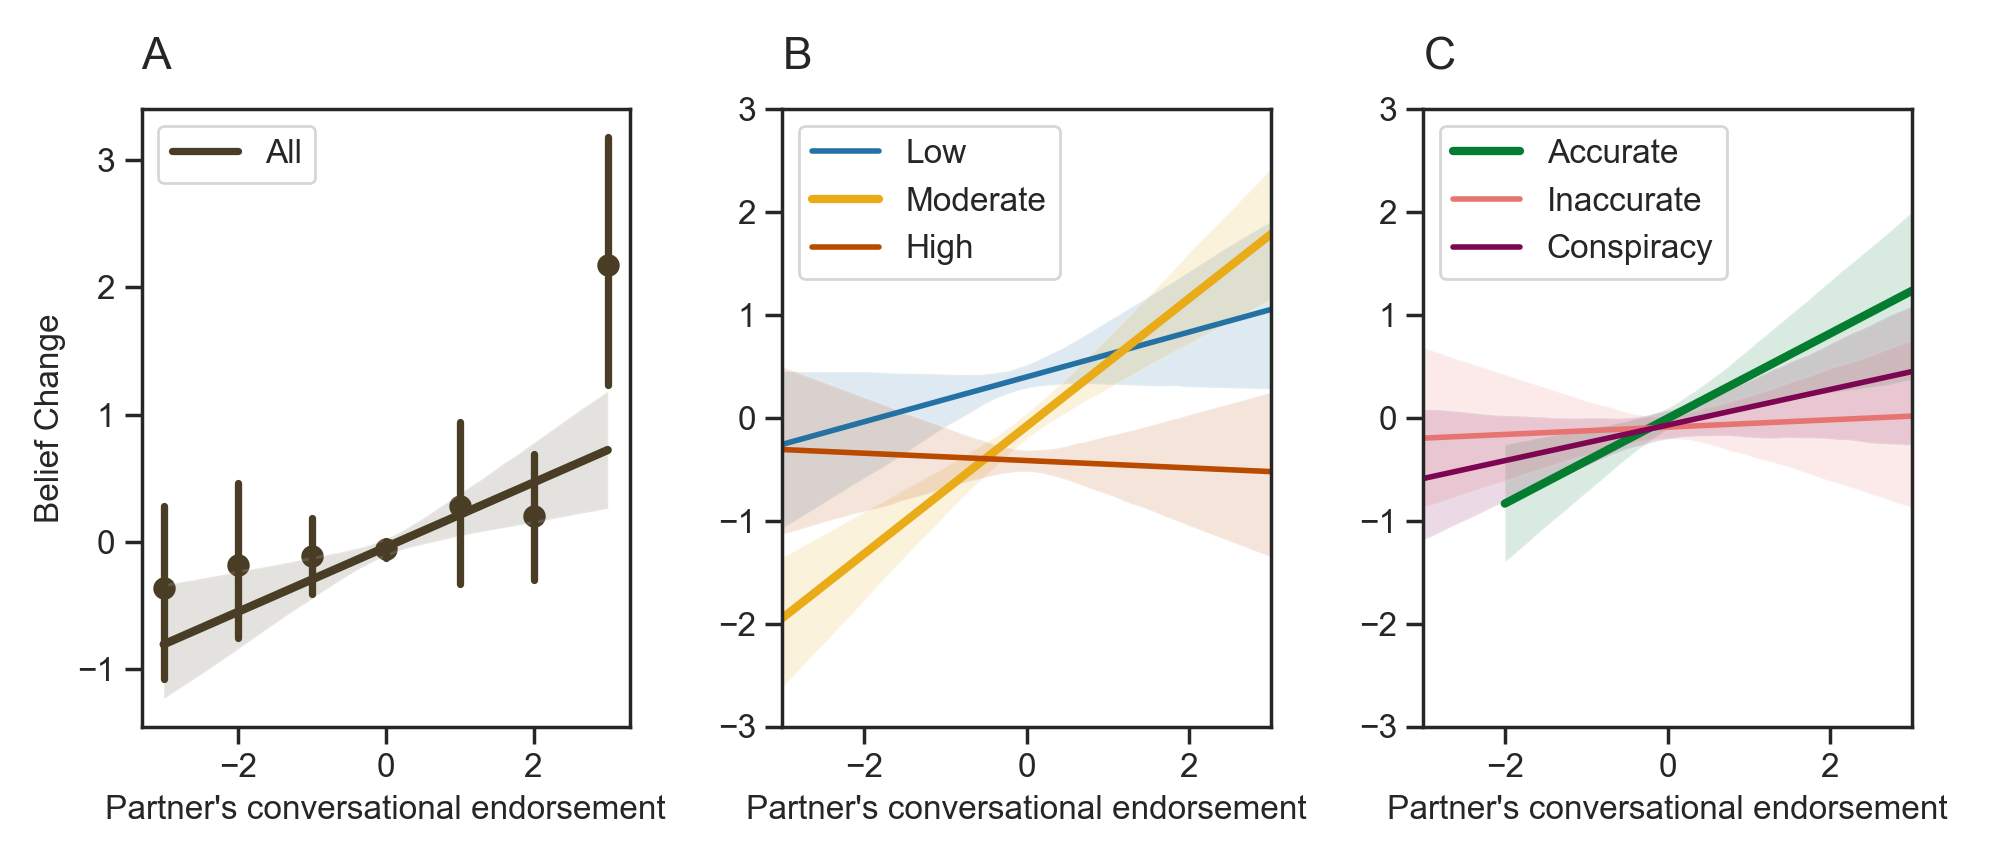

In [5]:
fig, ax = plt.subplots(1,3, figsize=(10,4.3))

sns.regplot(x=DATA.SpeakAgree, y=DATA.Change, scatter_kws={"color": "#493D26"}, \
            line_kws={"color":"#493D26","alpha":1,"lw":3}, x_estimator=np.mean, ax=ax[0])
ax[0].set_xlim([-3.3,3.3])
ax[0].set_ylabel('Belief Change')
ax[0].set(xlabel="Partner's conversational endorsement")
ax[0].legend(['All'])
bff.panellabel(ax[0], "A")

sns.regplot(x=DATA.loc[DATA.LMH==0, "SpeakAgree"], y=DATA.loc[DATA.LMH==0, "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#2471A3","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=DATA.loc[DATA.LMH==1, "SpeakAgree"], y=DATA.loc[DATA.LMH==1, "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#E9AB17","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=DATA.loc[DATA.LMH==2, "SpeakAgree"], y=DATA.loc[DATA.LMH==2, "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#BA4A00","alpha":1,"lw":2}, ax=ax[1])
bff.panellabel(ax[1], "B")
ax[1].set_ylim([-3,3])
ax[1].set_ylabel('')
ax[1].set(xlabel="Partner's conversational endorsement")
ax[1].legend(['Low', 'Moderate', 'High'])

sns.regplot(x=DATA.loc[DATA.FMC=="Fact", "SpeakAgree"], y=DATA.loc[DATA.FMC=="Fact", "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#057D31","alpha":1,"lw":3}, ax=ax[2])
sns.regplot(x=DATA.loc[DATA.FMC=="Myth", "SpeakAgree"], y=DATA.loc[DATA.FMC=="Myth", "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#E77471","alpha":1,"lw":2}, ax=ax[2])
sns.regplot(x=DATA.loc[DATA.FMC=="Conspiracy", "SpeakAgree"], y=DATA.loc[DATA.FMC=="Conspiracy", "Change"], scatter_kws={"s": 0}, \
            line_kws={"color":"#7D0552","alpha":1,"lw":2}, ax=ax[2])
ax[2].set_ylim([-3,3])
ax[2].set_ylabel('')
ax[2].set(xlabel="Partner's conversational endorsement")
ax[2].legend(['Accurate', 'Inaccurate', 'Conspiracy'])
bff.panellabel(ax[2], "C")

plt.tight_layout()
plt.savefig('figdyad.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


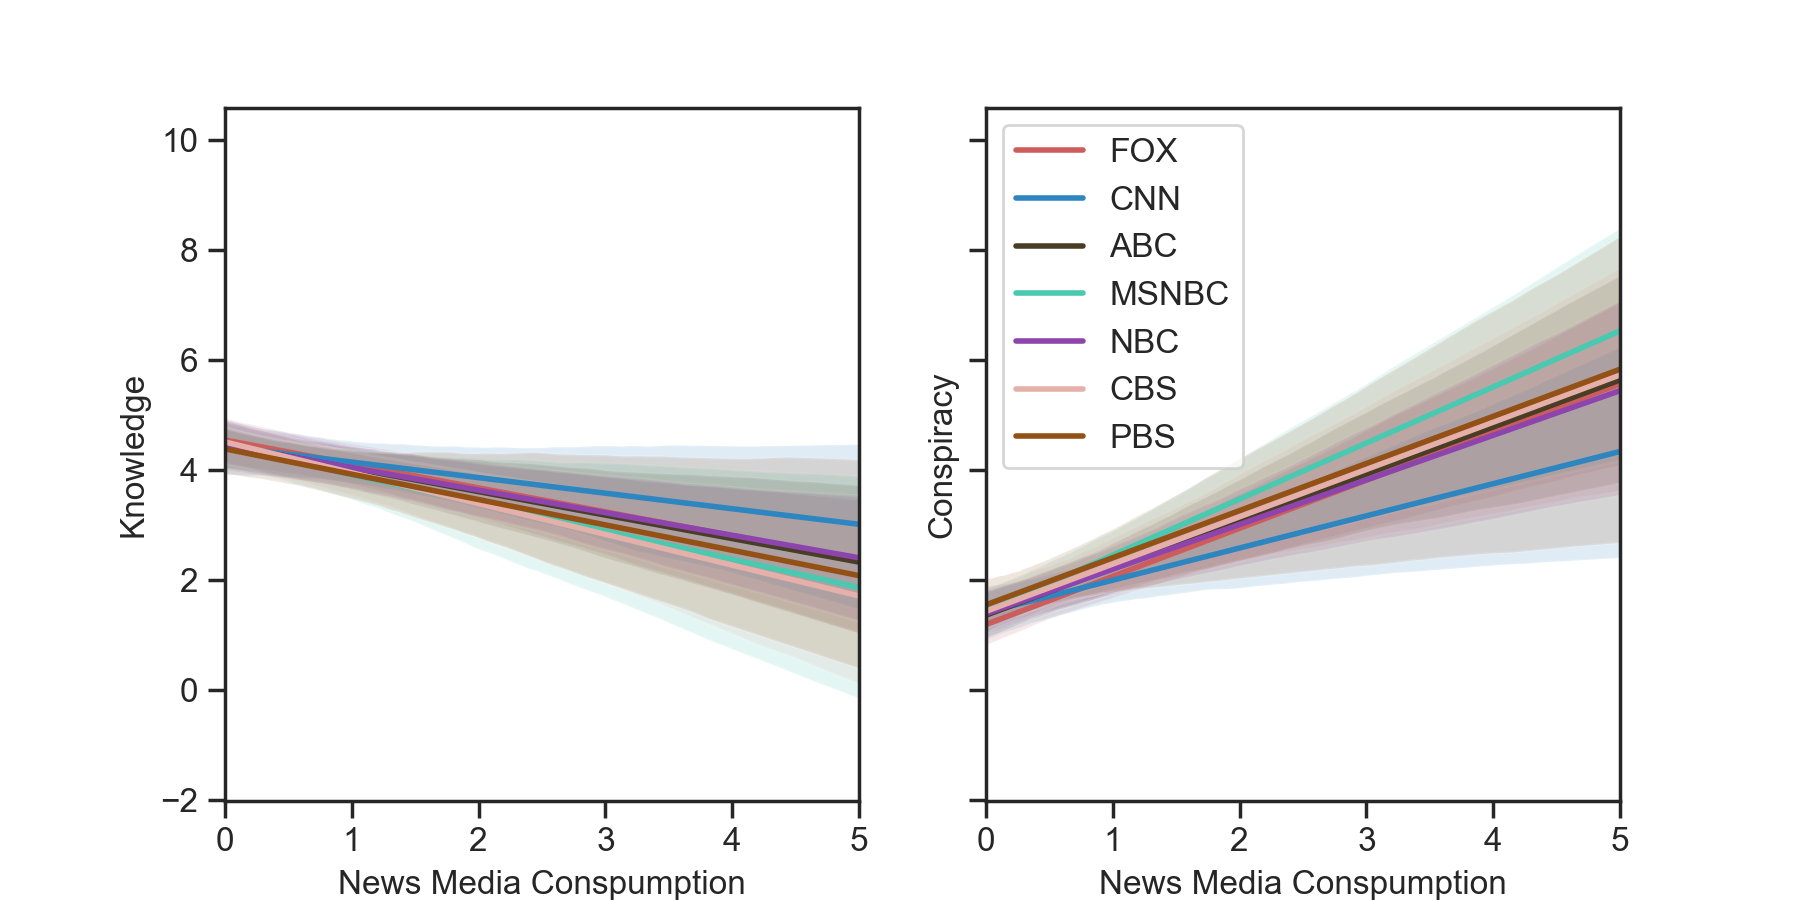

In [6]:
fig, ax = plt.subplots(1,2, figsize=(9,4.5), sharey=True)

sns.regplot(x=df.FOX, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.CNN, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.ABC, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#493D26","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.MSNBC, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#48C9B0","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.NBC, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#8E44AD","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.CBS, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#E6B0AA","alpha":1,"lw":2}, ax=ax[0])
sns.regplot(x=df.PBS, y=df.KNOWLEDGE_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#935116","alpha":1,"lw":2}, ax=ax[0])


#ax.set_xlim([-1.5,1.5])
ax[0].set_ylabel('Knowledge')
ax[0].set(xlabel='News Media Conspumption')
#ax[0].set_title("FOX and CNN", fontsize=18)
#stats.pearsonr(df.Trump, df.KNOWLEDGE_pre)


sns.regplot(x=df.FOX, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.CNN, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.ABC, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#493D26","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.MSNBC, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#48C9B0","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.NBC, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#8E44AD","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.CBS, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#E6B0AA","alpha":1,"lw":2}, ax=ax[1])
sns.regplot(x=df.PBS, y=df.CONSPIRACY_pre, scatter_kws={"s": 0}, \
            line_kws={"color":"#935116","alpha":1,"lw":2}, ax=ax[1])

#ax.set_xlim([-1.5,1.5])
ax[1].set_ylabel('Conspiracy', labelpad=10)
ax[1].set(xlabel='News Media Conspumption')
#ax[1].set_title("Facebook and Twitter", fontsize=18)
#stats.pearsonr(df.Fauci, df.KNOWLEDGE_pre)

plt.legend(labels=['FOX', 'CNN', 'ABC', 'MSNBC', 'NBC','CBS','PBS'])
plt.savefig('news.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


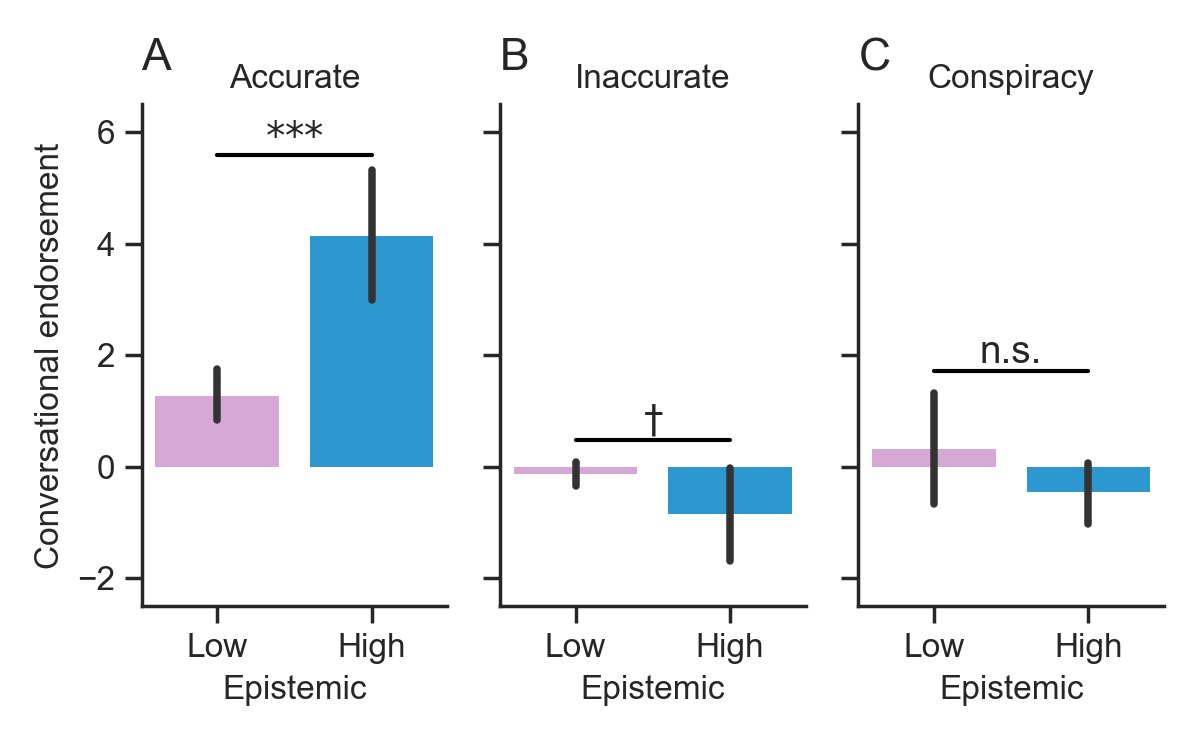

In [9]:
pal = ["#DDA0DD", "#12a1eb"]

fig, ax = plt.subplots(1,3, figsize=(6,3.7), sharey=True)

sns.barplot(x=df.Epistemic, y=df.FACT_AGREE, data=df, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.despine()
ax[0].set_xticklabels(["Low","High"])
ax[0].set_ylabel("Conversational endorsement")
ax[0].set(title = "Accurate")
bff.panellabel(ax[0], "A")

datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(df.loc[df.Epistemic==100, "FACT_AGREE"], \
                       df.loc[df.Epistemic==200, "FACT_AGREE"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)

sns.barplot(x=df.Epistemic, y=df.MISINFO_AGREE, data=df, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
sns.despine()
ax[1].set_xticklabels(["Low","High"])
ax[1].set_ylabel("", labelpad=8)
ax[1].set(title = "Inaccurate")
bff.panellabel(ax[1], "B")

datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(df.loc[df.Epistemic==100, "MISINFO_AGREE"], \
                       df.loc[df.Epistemic==200, "MISINFO_AGREE"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)

sns.barplot(x=df.Epistemic, y=df.CONSPIRACY_AGREE, data=df, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
sns.despine()
ax[2].set_xticklabels(["Low","High"])
ax[2].set_ylabel("", labelpad=8)
ax[2].set(title = "Conspiracy")
bff.panellabel(ax[2], "C")

datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_ind(df.loc[df.Epistemic==100, "CONSPIRACY_AGREE"], \
                       df.loc[df.Epistemic==200, "CONSPIRACY_AGREE"])
bff.barplot_annotate_brackets(ax[2], 0, 1, p, datahandles, dh=0.05, fs=14)

plt.ylim(-2.5,6.5)
plt.tight_layout()
plt.savefig('fig5.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


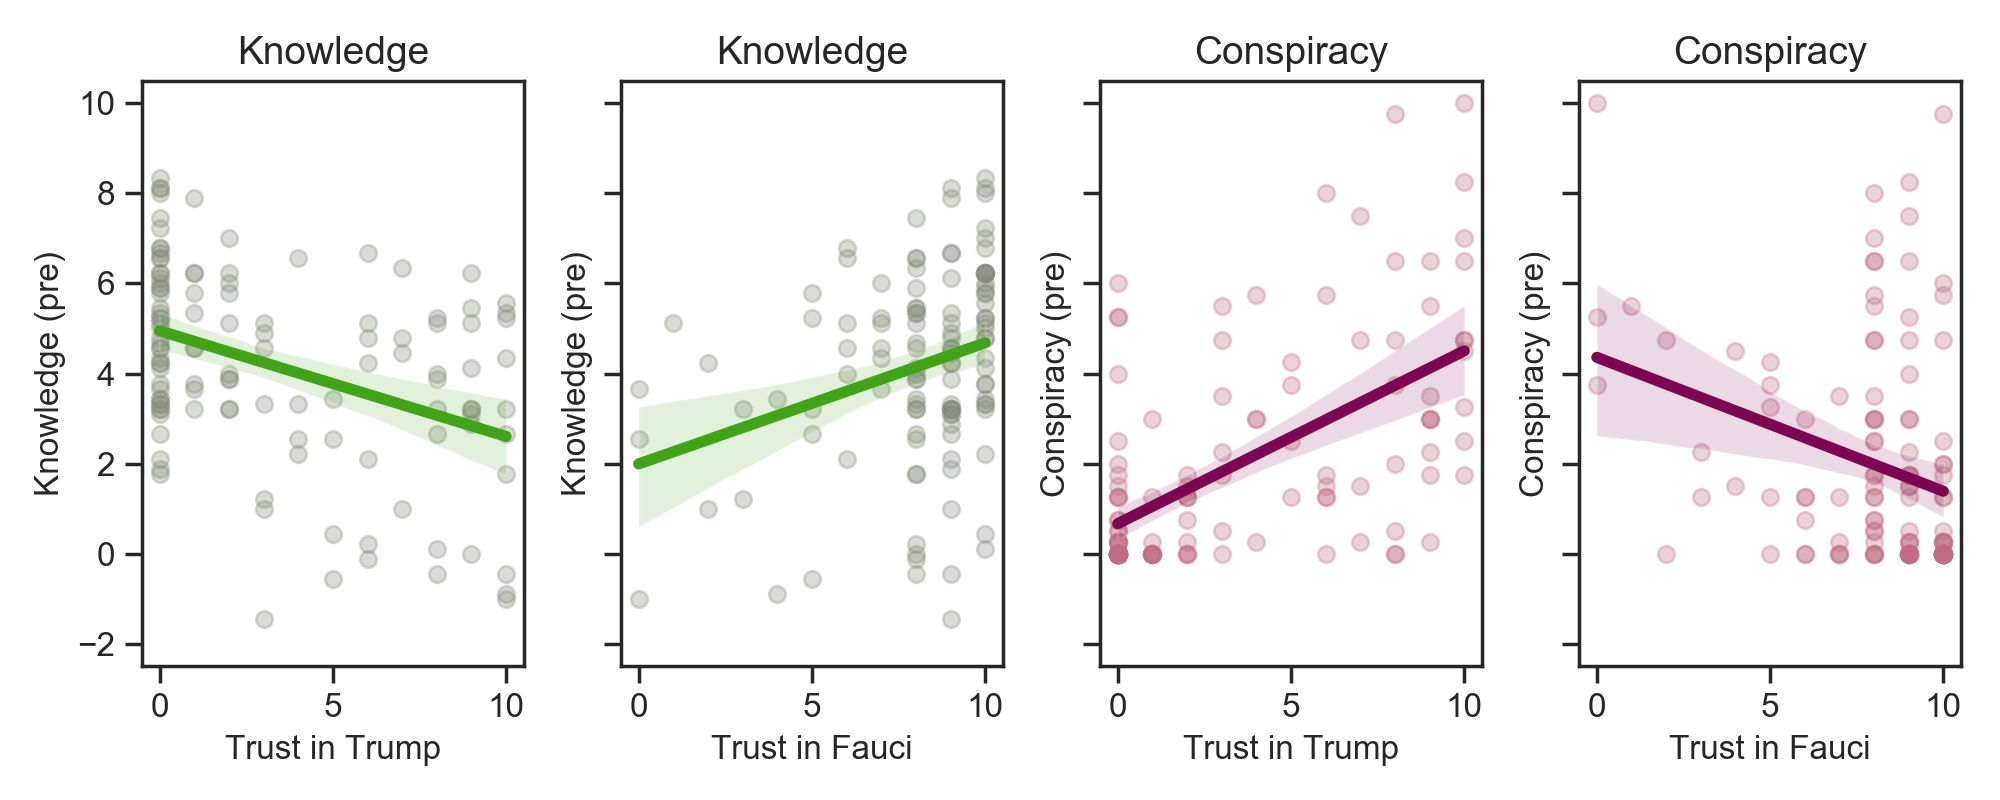

In [10]:
fig, ax = plt.subplots(1,4, figsize=(10,4), sharey=True)

sns.regplot(x=df.Trump, y=df.KNOWLEDGE_pre, scatter_kws={"color": "#848b79","alpha":.3}, \
            line_kws={"color":"#41A317","alpha":1,"lw":4}, ax=ax[0])
ax[0].set_ylabel('Knowledge (pre)')
ax[0].set(xlabel='Trust in Trump')
ax[0].set_title("Knowledge", fontsize=14)

sns.regplot(x=df.Fauci, y=df.KNOWLEDGE_pre, scatter_kws={"color": "#848b79","alpha":.3}, \
            line_kws={"color":"#41A317","alpha":1,"lw":4}, ax=ax[1])
ax[1].set_ylabel('Knowledge (pre)', labelpad=10)
ax[1].set(xlabel='Trust in Fauci')
ax[1].set_title("Knowledge", fontsize=14)


sns.regplot(x=df.Trump, y=df.CONSPIRACY_pre, scatter_kws={"color": "#C06C84","alpha":.3}, \
            line_kws={"color":"#7D0552","alpha":1,"lw":4}, ax=ax[2])
ax[2].set_ylabel('Conspiracy (pre)', labelpad=10)
ax[2].set(xlabel='Trust in Trump')
ax[2].set_title("Conspiracy", fontsize=14)


sns.regplot(x=df.Fauci, y=df.CONSPIRACY_pre, scatter_kws={"color": "#C06C84","alpha":.3}, \
            line_kws={"color":"#7D0552","alpha":1,"lw":4}, ax=ax[3])
ax[3].set_ylabel('Conspiracy (pre)', labelpad=10)
ax[3].set(xlabel='Trust in Fauci')
ax[3].set_title("Conspiracy", fontsize=14)

plt.ylim(-2.5,10.5)
plt.tight_layout()
plt.savefig('fig2.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


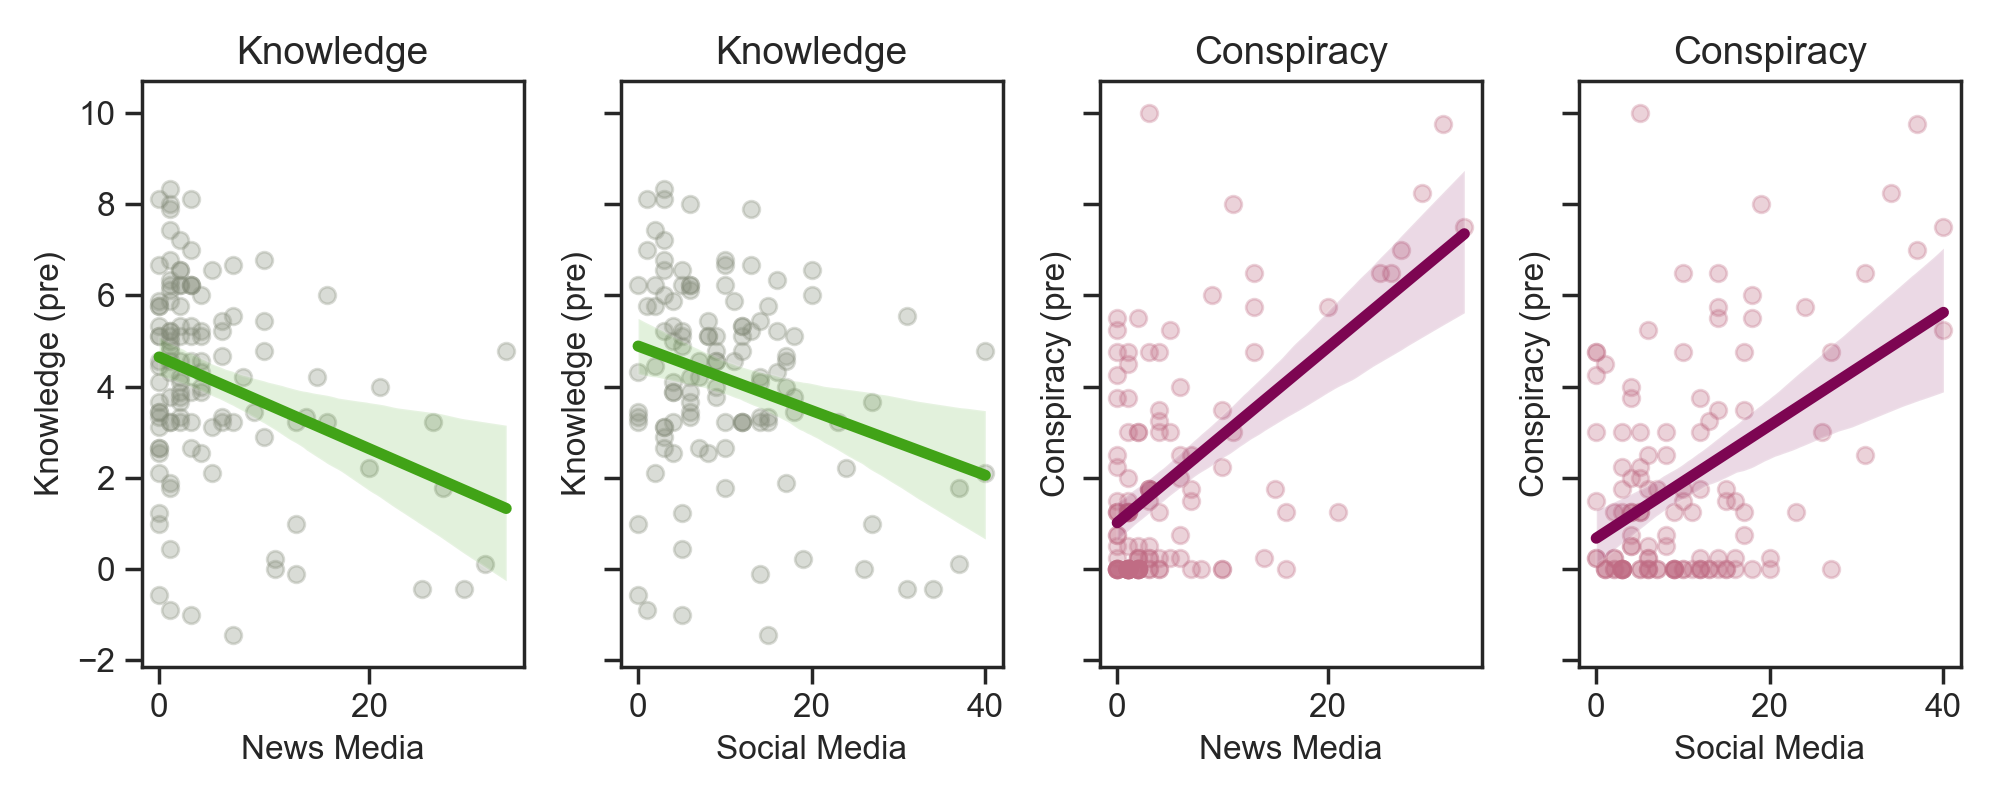

In [11]:
fig, ax = plt.subplots(1,4, figsize=(10,4), sharey=True)

sns.regplot(x=df.MEDIA, y=df.KNOWLEDGE_pre, scatter_kws={"color": "#848b79","alpha":.3}, \
            line_kws={"color":"#41A317","alpha":1,"lw":4}, ax=ax[0])
ax[0].set_ylabel('Knowledge (pre)')
ax[0].set(xlabel='News Media')
ax[0].set_title("Knowledge", fontsize=14)

sns.regplot(x=df.SocialMEDIA, y=df.KNOWLEDGE_pre, scatter_kws={"color": "#848b79","alpha":.3}, \
            line_kws={"color":"#41A317","alpha":1,"lw":4}, ax=ax[1])
ax[1].set_ylabel('Knowledge (pre)', labelpad=10)
ax[1].set(xlabel='Social Media')
ax[1].set_title("Knowledge", fontsize=14)


sns.regplot(x=df.MEDIA, y=df.CONSPIRACY_pre, scatter_kws={"color": "#C06C84","alpha":.3}, \
            line_kws={"color":"#7D0552","alpha":1,"lw":4}, ax=ax[2])
ax[2].set_ylabel('Conspiracy (pre)', labelpad=10)
ax[2].set(xlabel='News Media')
ax[2].set_title("Conspiracy", fontsize=14)


sns.regplot(x=df.SocialMEDIA, y=df.CONSPIRACY_pre, scatter_kws={"color": "#C06C84","alpha":.3}, \
            line_kws={"color":"#7D0552","alpha":1,"lw":4}, ax=ax[3])
ax[3].set_ylabel('Conspiracy (pre)', labelpad=10)
ax[3].set(xlabel='Social Media')
ax[3].set_title("Conspiracy", fontsize=14)

#plt.ylim(-2.5,10.5)
plt.tight_layout()
plt.savefig('fig3.tif', dpi=900, format="tiff")

In [16]:
# Load file (from same directory as the notebook)/

DAT = pd.read_excel(os.path.expanduser("DAT.xlsx"))
DAT.head()

,Partnum,PAIR,Epistemic,BeliefChange,Conv,Type
0,1101,36,100,0.222222,0,1
1,1102,37,100,0.555556,0,1
2,1106,38,100,0.444444,3,1
3,1108,36,100,0.444444,0,1
4,1112,39,100,0.666667,5,1


In [20]:
aov = pg.mixed_anova(dv='BeliefChange', within='Type', between='Epistemic', subject='PAIR', data=DAT)
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc  p-GG-corr              np2  eps    sphericity    W-spher    p-spher
-----------  -----  -----  -----  -----  -----  -------  -------------------  -----  -----  ------------  ---------  ---------------------
Epistemic    0.055      1     57  0.055  0.151    0.699  -                    0.003  -      -             -          -
Type         0.494      2    114  0.247  0.761    0.470  0.43796723726972897  0.013  0.8    False         0.749      0.0002671950966527025
Interaction  0.030      2    114  0.015  0.046    0.955  -                    0.001  -      -             -          -



In [21]:
aov = pg.mixed_anova(dv='Conv', within='Type', between='Epistemic', subject='PAIR', data=DAT)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2  eps
-----------  -------  -----  -----  -------  ------  -------  -----  -----
Epistemic      9.467      1     57    9.467   1.004    0.321  0.017  -
Type         333.774      2    114  166.887  20.582    0.000  0.265  0.91
Interaction  127.722      2    114   63.861   7.876    0.001  0.121  -



In [28]:
df.head()

,ParticipantID,PAIR,Epistemic,PARTNER Agreement:,PA_fact1,PA_fact2,PA_fact3,PA_fact4,PA_fact5,PA_fact6,...,Ide,MEDIA,SocialMEDIA,PREVENT,Unnamed: 202,FACT_AGREE,MISINFO_AGREE,CONSPIRACY_AGREE,Unnamed: 206,SocialSensitivity
0,1101,36,100,NaN,0,0,0,0,0,0,...,4,6,4,5.857143,NaN,0,-1,0,NaN,0.352664
1,1102,37,100,NaN,0,0,0,0,0,0,...,1,2,6,10.000000,NaN,0,0,-1,NaN,0.175614
2,1106,38,100,NaN,0,0,0,0,0,0,...,5,6,0,10.000000,NaN,3,0,2,NaN,0.524490
3,1108,36,100,NaN,0,0,0,0,0,0,...,9,13,14,10.000000,NaN,0,-1,0,NaN,-0.036627
4,1112,39,100,NaN,0,0,0,0,0,0,...,6,2,5,10.000000,NaN,5,1,1,NaN,-0.125586


In [34]:
%Rpush df

In [42]:
%%R

M <- lm(KNOWLEDGE_pre ~ Edu + Age + as.factor(Gender) + as.factor(Political) + Trump + Fauci + MEDIA + SocialMEDIA +
        ThreatCovid + AnxiousCovid_pre + DynamicAnxiety_pre + PANASpos_PRE + PANASneg_PRE, data = df)
print(summary(M))


Call:
lm(formula = KNOWLEDGE_pre ~ Edu + Age + as.factor(Gender) + 
    as.factor(Political) + Trump + Fauci + MEDIA + SocialMEDIA + 
    ThreatCovid + AnxiousCovid_pre + DynamicAnxiety_pre + PANASpos_PRE + 
    PANASneg_PRE, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7775 -0.9350  0.0261  1.0265  3.7929 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)  
(Intercept)                3.164743   1.402474   2.257   0.0262 *
Edu                       -0.006971   0.190613  -0.037   0.9709  
Age                        0.028431   0.015750   1.805   0.0740 .
as.factor(Gender)1         0.235105   0.361778   0.650   0.5173  
as.factor(Gender)3         1.896349   1.257256   1.508   0.1346  
as.factor(Political)bREPS -0.126335   0.545276  -0.232   0.8172  
as.factor(Political)I     -0.061774   0.471697  -0.131   0.8961  
as.factor(Political)O     -0.896573   0.938117  -0.956   0.3415  
Trump                     -0.142814   0.068553  -2.083   0.

In [43]:
%%R

M <- lm(CONSPIRACY_pre ~ Edu + Age + as.factor(Gender) + as.factor(Political) + Trump + Fauci + MEDIA + SocialMEDIA +
        ThreatCovid + AnxiousCovid_pre + DynamicAnxiety_pre + PANASpos_PRE + PANASneg_PRE, data = df)
print(summary(M))


Call:
lm(formula = CONSPIRACY_pre ~ Edu + Age + as.factor(Gender) + 
    as.factor(Political) + Trump + Fauci + MEDIA + SocialMEDIA + 
    ThreatCovid + AnxiousCovid_pre + DynamicAnxiety_pre + PANASpos_PRE + 
    PANASneg_PRE, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7856 -0.9054  0.0020  0.8118  4.7281 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.180850   1.231414   0.959 0.339880    
Edu                       -0.068793   0.167364  -0.411 0.681914    
Age                        0.005340   0.013829   0.386 0.700220    
as.factor(Gender)1        -0.501455   0.317652  -1.579 0.117548    
as.factor(Gender)3        -2.015411   1.103908  -1.826 0.070849 .  
as.factor(Political)bREPS  0.662700   0.478769   1.384 0.169356    
as.factor(Political)I      0.734958   0.414164   1.775 0.078984 .  
as.factor(Political)O      1.355556   0.823695   1.646 0.102934    
Trump                      0.232781   0.

In [47]:
# Load file (from same directory as the notebook)/

dfm = pd.read_excel(os.path.expanduser("media.xlsx"))
dfm.head()

,ParticipantID,MediaUse,Network,CONSPIRACY_pre,MEDIA
0,1101,0,MSNBC,4.00,6
1,1102,0,MSNBC,0.25,2
2,1106,1,MSNBC,0.25,6
3,1108,2,MSNBC,6.50,13
4,1112,0,MSNBC,3.00,2


In [48]:
%Rpush dfm

In [58]:
%%R

M <- lm(CONSPIRACY_pre ~ MediaUse*as.factor(Network) + (1 | ParticipantID), data = dfm)
print(summary(M))


Call:
lm(formula = CONSPIRACY_pre ~ MediaUse * as.factor(Network) + 
    (1 | ParticipantID), data = dfm)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.5234 -1.4286 -0.7715  1.4534  8.6411 

Coefficients: (1 not defined because of singularities)
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       1.358910   0.228314   5.952 3.94e-09 ***
MediaUse                          0.854689   0.152353   5.610 2.78e-08 ***
as.factor(Network)CBS             0.069726   0.320016   0.218    0.828    
as.factor(Network)CNN             0.051029   0.337438   0.151    0.880    
as.factor(Network)FOX            -0.169521   0.327222  -0.518    0.605    
as.factor(Network)MSNBC           0.071884   0.317120   0.227    0.821    
as.factor(Network)NBC             0.024829   0.322471   0.077    0.939    
as.factor(Network)PBS             0.187682   0.319284   0.588    0.557    
1 | ParticipantIDTRUE                   NA         NA      NA       